# Intro
Analysis of daily heart rate data over first 2 months of fitbit use.

In [117]:
# imports

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatch
import numpy as np
from datetime import datetime

In [135]:
# import data
allHeartDF = pd.read_csv('working/allHeart.csv', index_col=0)

# convert datatype
allHeartDF['date'] = pd.to_datetime(allHeartDF['date'], format='%Y-%m-%d')

# add day of week (0 = Monday, 6 = Sunday)
allHeartDF['weekDay'] = allHeartDF['date'].dt.dayofweek

# add day name
allHeartDF['dayName'] = allHeartDF['date'].dt.day_name()

# rename columsnas all min and max inverted - will amend api script but don't want to rerun now
allHeartDF.rename(columns={'normal_min': 'normal_max', 'normal_max': 'normal_min', 'fatBurn_min': 'fatBurn_max', 'fatBurn_max': 'fatBurn_min', 'cardio_min': 'cardio_max', 'cardio_max': 'cardio_min'}, inplace=True)

# preview data and confirm datatypes
print('Data preview: \n' 
        +str(allHeartDF.head()) +'\n'
        +'\n'
        'Check datatypes: \n' 
        +str(allHeartDF.dtypes))



Data preview: 
        date  restingHeartRate  normal_max  normal_min  normal_minutes  \
0 2022-04-21                58         107          30            1396   
1 2022-04-22                58         107          30            1437   
2 2022-04-23                58         107          30            1405   
3 2022-04-24                58         106          30            1439   
4 2022-04-25                58         107          30            1411   

   fatBurn_max  fatBurn_min  fatBurn_minutes  cardio_max  cardio_min  \
0          132          107               42         163         132   
1          132          107                3         163         132   
2          132          107               35         163         132   
3          131          106                1         163         131   
4          132          107               28         163         132   

   cardio_minutes  weekDay   dayName  
0               2        3  Thursday  
1               0        4   

# Data explanation
This is daily data, meaning there is adate and single data entry for each day, always in bpm (beats per minute). Note that date format is yyyy-mm-dd (ie year, month, day). 

Firstly, there are two heart rate parameters Fitbit calculates that aren't shown here:
Maximum heart rate is commonly defined as "220 - age", in my case "220-38 = 182"
Heart rate reserve is the difference between resting heart rate and max heart rate, in my case "182 - 58 = 124". 

Secondly, Fitbit determines resting heart rate (restingHeartRate in the dataframe) by recording heart rate when asleep or awake but inactive (no steps detected) according to a proprietary algorithm. Resting heart rates are generally 60 - 100 bpm, with lower resting heart rates indicative of good heart health.

Then there are 3 heart rate zones:  

normal = Fitbit calls this "below zones" or "out of range", by which it means "not in a fat burn or cardio zone". I have called it "normal" as it is typical heart rate when going about day-to-day activities.  

fatBurn = the first training zone, defined as 40-59% of heart rate reserve + resting heart rate, that is:  
&emsp; fat burn zone bottom = $(0.4 * heart\ rate\ reserve) + resting\ heart\ rate$  
&emsp; fat burn zone top = $(0.59 * heart\ rate\ reserve) + resting\ heart\ rate$  

cardio = the second training zone, 60-84% of heart rate reserve + resting heart rate, that is:  
&emsp; cardio zone bottom = $(0.6 * heart\ rate\ reserve) + resting\ heart\ rate$  
&emsp; cardio zone top = $(0.84 * heart\ rate\ reserve) + resting\ heart\ rate$ 

peak = peak training zone, defined as 85% of heart rate reserve + resting heart rate to max heart rate, that is:   
&emsp; peak zone bottom = $(0.85 * heart\ rate\ reserve) + resting\ heart\ rate$  
&emsp; peak zone top = max heart rate


See [here](https://help.fitbit.com/articles/en_US/Help_article/1565.htm) for more info on Fitbit heart rate zones.

In [50]:
# my heart rate zone calculations, according to fitbit

age = 38
restingHeartRate = allHeartDF['restingHeartRate'].mean()

maxHeartRate = 220 - age # commonly defined as "220 - age"
heartRateReserve = int(maxHeartRate - restingHeartRate)
 
# normal zone boundaries - its not clear how Fitbit calculated this, so I've used their values
normalZoneBottom = allHeartDF['normal_min'][0]
normalZoneTop = allHeartDF['normal_max'][0]

# fat burn zone boundaries
fatBurnZoneBottom = (0.4 * heartRateReserve) + restingHeartRate
fatBurnZoneTop = (0.59 * heartRateReserve) + restingHeartRate

# cardio zone boundaries
cardioZoneBottom = (0.6 * heartRateReserve) + restingHeartRate
cardioZoneTop = (0.84 * heartRateReserve) + restingHeartRate

# peak zone
peakZoneBottom = (0.85 * heartRateReserve) + restingHeartRate
peakZoneTop = maxHeartRate

# print
print(f"\
    My heart rate zones are: \n\
    Maximum Heart Rate: {maxHeartRate} \n\
    Heart Rate Reserve: {heartRateReserve} \n\
    Resting Heart Rate: {restingHeartRate:.0f} \n\
    Normal Zone: {normalZoneBottom:.0f} - {normalZoneTop:.0f} \n\
    Fat Burn Zone: {fatBurnZoneBottom:.0f} - {fatBurnZoneTop:.0f} \n\
    Cardio Zone: {cardioZoneBottom:.0f} - {cardioZoneTop:.0f} \n\
    Peak Zone: {peakZoneBottom:.0f} - {peakZoneTop:.0f} ")

    My heart rate zones are: 
    Maximum Heart Rate: 182 
    Heart Rate Reserve: 124 
    Resting Heart Rate: 58 
    Normal Zone: 30 - 107 
    Fat Burn Zone: 108 - 131 
    Cardio Zone: 132 - 162 
    Peak Zone: 163 - 182 


## Bar plots of my hert rate zones

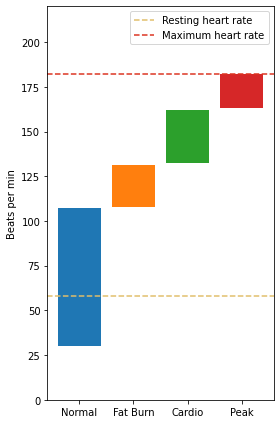

In [92]:
# plot as stacked bar
# create figure
fig, ax = plt.subplots(figsize=(4, 6))

xlabels = ["Normal", "Fat Burn", "Cardio", "Peak"]

# calculate zone sizes
# these are needed to plot one above the other in stacked bar chart
normalZoneSize = normalZoneTop - normalZoneBottom
fatBurnZoneSize = fatBurnZoneTop - fatBurnZoneBottom
cardioZoneSize = cardioZoneTop - cardioZoneBottom
peakZoneSize = peakZoneTop - peakZoneBottom

# add plots
plt.bar(xlabels[0], normalZoneSize, bottom=normalZoneBottom)
plt.bar(xlabels[1], fatBurnZoneSize, bottom=fatBurnZoneBottom)
plt.bar(xlabels[2], cardioZoneSize, bottom=cardioZoneBottom)
plt.bar(xlabels[3], peakZoneSize, bottom=peakZoneBottom)

# amend y axis
plt.ylim(0, 220)

# add lines
plt.axhline(y=restingHeartRate, color='#E1BE6A', linestyle='--', linewidth=1.5, label="Resting heart rate")
plt.axhline(y=maxHeartRate, color='#DC3220', linestyle='--', linewidth=1.5, label="Maximum heart rate")

# labels
plt.ylabel("Beats per min")
plt.legend()

plt.tight_layout()


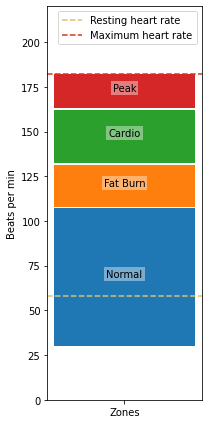

In [89]:
# plot as stacked bar
# create figure
fig, ax = plt.subplots(figsize=(3, 6))

xlabel = ["Zones"]

# calculate zone sizes
# these are needed to plot one above the other in stacked bar chart
normalZoneSize = normalZoneTop - normalZoneBottom
fatBurnZoneSize = fatBurnZoneTop - fatBurnZoneBottom
cardioZoneSize = cardioZoneTop - cardioZoneBottom
peakZoneSize = peakZoneTop - peakZoneBottom
# zone half size list - needed for plot annotation later on
zoneHalfSizes = [(normalZoneTop-(normalZoneSize/2)), 
                (fatBurnZoneTop-(fatBurnZoneSize/2)), 
                (cardioZoneTop-(cardioZoneSize/2)), 
                (peakZoneTop-(peakZoneSize/2))]

# add plots
plt.bar(xlabel, normalZoneSize, bottom=normalZoneBottom) 
plt.bar(xlabel, fatBurnZoneSize, bottom=fatBurnZoneBottom)
plt.bar(xlabel, cardioZoneSize, bottom=cardioZoneBottom)
plt.bar(xlabel, peakZoneSize, bottom=peakZoneBottom)

# amend y axis
plt.ylim(0, 220)

# add lines
plt.axhline(y=restingHeartRate, color='#E1BE6A', linestyle='--', linewidth=1.5, label="Resting heart rate")
plt.axhline(y=maxHeartRate, color='#DC3220', linestyle='--', linewidth=1.5, label="Maximum heart rate")

# labels
plt.ylabel("Beats per min")

barLabels = ["Normal", "Fat Burn", "Cardio", "Peak"]
hLineLabels = ["Resting Heart Rate", "Maximum Heart Rate"]
for i in range(len(barLabels)):
    plt.annotate(barLabels[i], (xlabel, zoneHalfSizes[i]), ha='center', bbox={'facecolor': 'white', 'alpha': 0.4, 'edgecolor': 'none', 'pad': 2})
plt.legend()

# display
plt.tight_layout()

## Plots of time in each zone

In [137]:
# gather data

zoneTimeDF = allHeartDF[['date', 'weekDay', 'dayName', 'normal_minutes', 'fatBurn_minutes', 'cardio_minutes']]
zoneTimeDF.head()

,date,weekDay,dayName,normal_minutes,fatBurn_minutes,cardio_minutes
0,2022-04-21,3,Thursday,1396,42,2
1,2022-04-22,4,Friday,1437,3,0
2,2022-04-23,5,Saturday,1405,35,0
3,2022-04-24,6,Sunday,1439,1,0
4,2022-04-25,0,Monday,1411,28,1


In [138]:
# gropu by weekday and calc mean, min and max for all zones
zoneTimeGroupedByDay = zoneTimeDF.groupby('dayName').agg({'normal_minutes': ['mean', 'max', 'min'], 'fatBurn_minutes': ['mean', 'max', 'min'], 'cardio_minutes': ['mean', 'max', 'min']}).reset_index()

# rename columns
#zoneTimeGroupedByDay.columns['weekDay', 'normal_mean', 'normal_max', 'normal_min', 'fatBurn_mean', 'fatBurn_max', 'fatBurn_min', 'cardio_mean', 'cardio_max', 'cardio_min']

zoneTimeGroupedByDay

dayName normal_minutes             fatBurn_minutes          \
                       mean   max   min            mean max min   
0     Friday    1421.444444  1439  1382       18.111111  57   1   
1     Monday    1418.250000  1435  1401       21.375000  37   5   
2   Saturday    1422.888889  1440  1405       17.111111  35   0   
3     Sunday    1421.000000  1439  1392       18.888889  48   1   
4   Thursday    1406.666667  1429  1365       32.777778  74  11   
5    Tuesday    1404.375000  1424  1377       34.125000  63  16   
6  Wednesday    1415.375000  1436  1380       23.625000  57   4   

  cardio_minutes          
            mean max min  
0       0.444444   2   0  
1       0.375000   2   0  
2       0.000000   0   0  
3       0.111111   1   0  
4       0.555556   2   0  
5       1.500000   8   0  
6       0.875000   5   0

In [145]:
zoneTimeGroupedByDay.iloc[0][0]

'Friday'

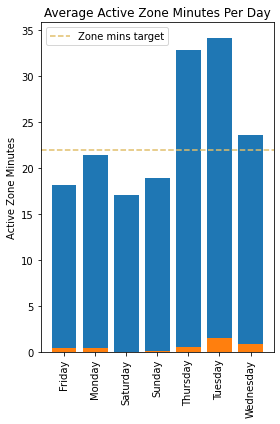

In [156]:
# plot fatburn and cardio minutes by day

fix, ax = plt.subplots(figsize=(4, 6))

# plot
plt.bar(zoneTimeGroupedByDay['dayName'], zoneTimeGroupedByDay['fatBurn_minutes']['mean'])
plt.bar(zoneTimeGroupedByDay['dayName'], zoneTimeGroupedByDay['cardio_minutes']['mean'])

# add target line
plt.axhline(y=22, color='#E1BE6A', linestyle='--', linewidth=1.5, label="Zone mins target")

# labels
plt.legend()
plt.xticks(rotation=90.0)
plt.ylabel("Active Zone Minutes")
plt.title("Average Active Zone Minutes Per Day")
# display
plt.tight_layout()


## Weekly target met plot (zone mins)
Fitbit sets a default goal of 22 Active Zone Minutes per day.
1 min in Fat Burn Zone earns 1 Active Zone Minutes
2 mins in Cardio or Peak Zones earns 2 Active Zone Minutes

In [132]:
# calc active zone minutes and append to DF

allHeartDF['zone_mins'] = allHeartDF['fatBurn_minutes'] + (allHeartDF['cardio_minutes'] *2)

# create categorical dataset
zoneMinsTarget = 22
zoneMinsTargetMet = (allHeartDF['zone_mins'].tail(7) > zoneMinsTarget).tolist()
# create a [2,7] array of zeroes
zoneMinsTargetMetArray = np.zeros([2, 7], dtype=int)

# populate with 1/0
for i in range(len(zoneMinsTargetMet)):
    if zoneMinsTargetMet[i] == True:
        zoneMinsTargetMetArray[0][i] +=1
    else:
        zoneMinsTargetMetArray[1][i] +=1

zoneMinsTargetMetArray

array([[0, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0]])

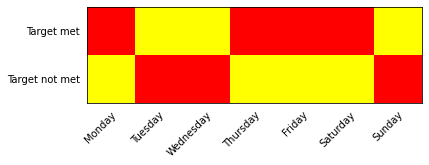

In [136]:
# list out last 7 days
heatMapLabels = allHeartDF['dayName'].tail(7).tolist()

# create plot
fig, ax = plt.subplots()

# set x ticklabels as days, rotate, right align
ax.set_xticks(np.arange(len(heatMapLabels)), labels=heatMapLabels, rotation=45.0, ha="right", rotation_mode="anchor")
# hide tick markers
ax.tick_params(which="major", bottom=False, left=False)

# from matplotlib import colors
im = ax.imshow(zoneMinsTargetMetArray, cmap='autumn')

# set y ticks as Yes / No
yLabels = ["Target met", "Target not met"]
ax.set_yticks(np.arange(len(yLabels)), labels=yLabels)

plt.show()